<a href="https://colab.research.google.com/github/RituAnilkumar/nnrms/blob/main/day9/GEE_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center"> Google Earth Engine Python API Tutorial </h1>

<p align="center"> Author: Ritu Anilkumar. Email at ritu.anilkumar@nesac.gov.in</p>

<p align="center"> Updated on 1 February 2024 </p>

Link: https://colab.research.google.com/drive/1DKX-0UvuOiH9Q_yfbAzO-E0SXhHqyFnX?usp=sharing

# Introduction to Earth Engine
<p align="justify">Satellites consist of a large number of sensors providing large quantities of a variety of data for use in real-time models/analysis to provide accurate inputs for governance, planning and day to day life. In Earth Observation, we have large volumes of data ranging from 10-20 TB/day (I’m getting varying numbers in different papers, so I just put a range), a large variety of sensors acquiring data over different regions of the electromagnetic spectrum and lots of data in different formats. These datasets can be used for different models or analysis, let’s take the example of assessing crop damage for providing compensation to the farmers. We will need to provide real-time output to the govt. Agencies and these must be very accurate. Thus the need for velocity and veracity. Together these make up the commonly known 4Vs of Big data. Now that we categorize satellite data as big data, let’s see how we can work with it.</p>

<p align="justify">For using this data, we can use high end PCs or workstations, very good GPU systems, High Performance Computers etc. But for an everyday user from a regular Line Dept, this is difficult to obtain. Working on lower end systems takes several hours and days to process the data before any useful results can be obtained. This is more so difficult if you want to study global phenomenon or time variant phenomenon. My next few sentences are to make things more clear. It is largely derived from the Earth Engine tutorials by Noel Gorelick/Nick Clinton. The user has the question to answer but is unable to work with the large volumes of data. So it is often easier to take the questions to the data than vice versa. Consider again the example of the compensation for farmers across a state or country. We will need to assess the change of the crop before and after the disaster across large areas. Processing this on regular systems will require large volumes of data to be downloaded, processed (in our low-end systems) and made into maps. Instead, we can directly work on external high-end servers where the data is pre-loaded and download the maps directly. This will save our time in data download and processing.</p>

<p align="justify">One technique of doing the above is the use of Google Earth Engine. Earth engine can be used using either the JavaScript or Python API. This tutorial is an introduction to the Python API of Google Earth Engine. We can import the Earth Engine library like any other library using the import function. This makes most functions fairly similar to the JavaScript API. So let's dig in. </p>

# Authenticate and initialize Earth Engine.

Our first step is to authenticate Earth Engine and initialize using our username and password. In case you haven't registered for Earth Engine, please do so [here](https://earthengine.google.com/signup/). Once you have your login credentials, please click the link that appears and grant the Earth Engine Authenticator to proceed with the tutorial. The provided link should be pasted into the space demarcated for the same.

In [1]:
# Import the earth engine library and authenticate with your credentials
import ee
ee.Authenticate()
ee.Initialize(project='graphic-boulder-279718')

In [2]:
#Install and import geemap for alternative to using folium for map display and sampleRect for numpy array creation
!pip install geemap
# import geemap.eefolium as emap
import geemap
# Import GDAL, NumPy, and matplotlib
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.1 MB/s eta 0:00:00


# Accessing and Displaying the datasets

The best part about using Google Earth Engine is that we don't have to go through the hassle of downloading the data. Petabytes of data is stored in their Data Catagolue from Landsat series of sensors to Sentinel series, MODIS, SRTM, ALOS, ERA5 Climate Reananlysis, land surface temperature, night lights and so on. For an extensive list of datasources ingested into Google Earth Engine see [here](https://developers.google.com/earth-engine/datasets/). In the next code snippet, we will see how we can access this data and perform some simple visualizations.

In [3]:
#Define aoi over which we will run the classification
aoi=ee.Geometry.Polygon([[[91.62456970214842, 26.291270819386938],[91.62456970214842, 26.08547356351828],[91.90746765136717, 26.08547356351828],[91.90746765136717, 26.291270819386938]]])

In [4]:
#Import the image collection of the global land use land cover for 2015
lulc2015=ee.ImageCollection('COPERNICUS/Landcover/100m/Proba-V/Global').mosaic().select('discrete_classification')
pprint(lulc2015.getInfo())

{'bands': [{'crs': 'EPSG:4326',
            'crs_transform': [1, 0, 0, 0, 1, 0],
            'data_type': {'max': 255,
                          'min': 0,
                          'precision': 'int',
                          'type': 'PixelType'},
            'id': 'discrete_classification'}],
 'type': 'Image'}


See the Earth Engine datasets for the PROBA data. Look at the bands and what the classes represent. We are combining the classes available into the classes we desire, namely water (class number 1), forest (class number 2), other vegetation (class number 3), barren (class number 4), urban (class number 5), ice (class number 6) and unclassified (class number 0). We can then combine them into a single image and view it

In [5]:
#Reclassify the PROBA classes to classes of our interest
unclass=lulc2015.eq(0)
water=lulc2015.eq(200).Or(lulc2015.eq(80))
forest=lulc2015.gte(111).And(lulc2015.neq(200))
urban=lulc2015.eq(50)
barren=lulc2015.eq(60)
ice=lulc2015.eq(70)
other_veg=(lulc2015.gte(20).And(lulc2015.lte(40))).Or(lulc2015.eq(90))
reclass_im=water.multiply(1).add(forest.multiply(2)).add(urban.multiply(5)).add(barren.multiply(4)).add(ice.multiply(6)).add(other_veg.multiply(3)).add(unclass.multiply(0))

In [6]:
#Use geemap's Map function to display the Earth Engine image. Do zoom to the aoi
Map = geemap.Map()
Map.addLayer(aoi,{'color':'FF0000'},'AOI')
Map.addLayer(reclass_im.clip(aoi), {'min': 0,'max': 7,'palette':['black','Teal','DarkGreen','Chartreuse','yellow','grey','white']}, 'Classified LULC')
Map.addLayerControl()
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [7]:
pprint(reclass_im.getInfo())

{'bands': [{'crs': 'EPSG:4326',
            'crs_transform': [1, 0, 0, 0, 1, 0],
            'data_type': {'max': 21,
                          'min': 0,
                          'precision': 'int',
                          'type': 'PixelType'},
            'id': 'discrete_classification'}],
 'type': 'Image'}


## Exercise: Try the same with Image collection VITO/PROBAV/C1/S1_TOC_100M

In [19]:
im_col=ee.ImageCollection("VITO/PROBAV/C1/S1_TOC_100M").filterBounds(aoi)

premon_im=im_col.filterDate(ee.Date('2015-01-01'),ee.Date('2015-04-30')).filterMetadata('CLOUD_COVER_PERCENTAGE','less_than',15).sort('CLOUD_COVER_PERCENTAGE',False).median()

In [20]:
Map = geemap.Map()
Map.addLayer(premon_im.clip(aoi), {'min': 0,'max': 1000,'bands':['NIR','RED','BLUE']}, 'Image pre')
Map.addLayerControl()
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

# Machine Learning with GEE Functions

In [21]:
training_samples=reclass_im.stratifiedSample(50,'discrete_classification',aoi,scale=100,geometries=True)
pprint(training_samples.first().getInfo())

{'geometry': {'coordinates': [91.81186445579364, 26.23125545393209],
              'geodesic': False,
              'type': 'Point'},
 'id': '0',
 'properties': {'discrete_classification': 1},
 'type': 'Feature'}


In [22]:
bands=premon_im.bandNames(); #Or list of bands as: ['RED','NIR']
trainingSamples=premon_im.select(bands).sampleRegions(training_samples,['discrete_classification'],100,geometries=True);


In [23]:
#Training the RF Classifier for utilizing in the classification using full image with indices
classifierTrainRF=ee.Classifier.smileRandomForest(100).train(trainingSamples,'discrete_classification',bands);

ClassifiedImageRF=premon_im.select(bands).classify(classifierTrainRF);

In [24]:
Map = geemap.Map()
Map.addLayer(ClassifiedImageRF.clip(aoi),{'min': 0,'max': 7,'palette':['black','Teal','DarkGreen','Chartreuse','yellow','grey','white']},'Classified Image RF',1)
Map.addLayerControl()
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

# Machine Learning with Earth Engine and Scikit Learn

## Converting the data to numpy and plotting

In order to use standard Python libraries of scikit learn, Pytorch etc with Earth Engine, the first step is to convert the data into numpy format. Let's do this using sampleRectangle and display the data using imshow.

In [25]:
reclass_im2=reclass_im.reproject(crs= lulc2015.select('discrete_classification').projection().crs(),scale=100)

In [26]:
# Get 2-d pixel array for AOI - returns feature with 2-D pixel array as property per band.
band_arrs = reclass_im2.sampleRectangle(region=aoi)

In [27]:
lulc_np=np.array(band_arrs.get('discrete_classification').getInfo())

In [28]:
lulc_np.shape

(230, 315)

In [29]:
lulc_np.max()

5

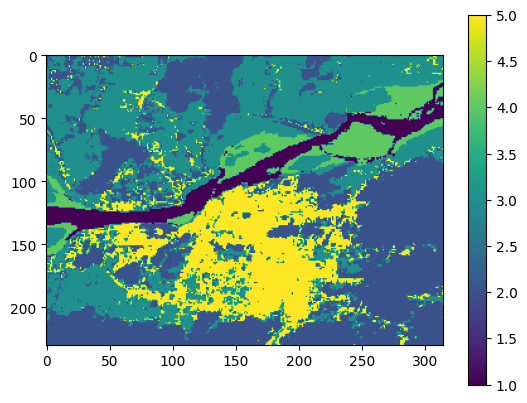

In [30]:
#Display the reclassified numpy image using matplotlib
# Plotting in greyscale
plt.imshow(lulc_np[:,:],cmap=plt.cm.viridis)
plt.colorbar()

In [31]:
premon_im=premon_im.reproject(crs= premon_im.select('RED').projection().crs(),scale=100)

In [32]:
# Get 2-d pixel array for AOI - returns feature with 2-D pixel array as property per band.
premon_np = geemap.ee_to_numpy(ee_object=premon_im,region=aoi)

In [33]:
premon_np.shape

(230, 315, 13)

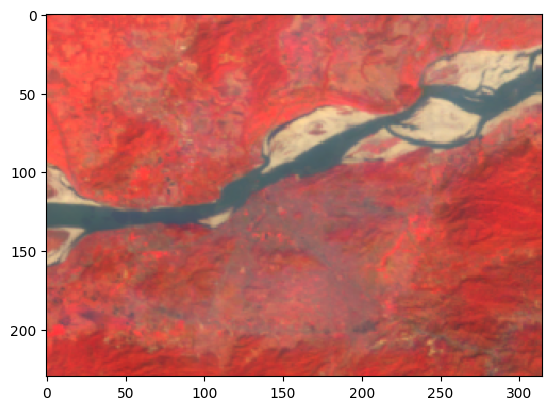

In [34]:
colorComb=np.array([1,0,2]) #Order determined by the order in the select() in the cloud masking and return
FCCim=premon_np[:,:,colorComb]
maxVal=max(premon_np[:,:,2].max(),premon_np[:,:,1].max(),premon_np[:,:,0].max())
minVal=min(premon_np[:,:,2].min(),premon_np[:,:,1].min(),premon_np[:,:,0].min())
FCCim=FCCim/(maxVal-minVal)
plt.imshow(FCCim)

## Preparing the data for machine learning

In [35]:
# Importing the classification algorithm and a module to split dataset into training and testing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(premon_np[:,:,:], lulc_np[:,:], test_size = 0.3, random_state = 42)

In [36]:
train_features.shape

(161, 315, 13)

In [37]:
train_labels.shape

(161, 315)

In [38]:
test_features.shape

(69, 315, 13)

In [39]:
test_labels.shape

(69, 315)

In [40]:
# The image needs to be reshaped into an array
new_shape = (train_features.shape[0] * train_features.shape[1], train_features.shape[2])

train_features_array = train_features.reshape(new_shape)
train_label_array=train_labels.reshape(train_labels.shape[0]*train_labels.shape[1])
print('New Training Features Shape:', train_features_array.shape)
print('New Training Labels Shape:', train_label_array.shape)

New Training Features Shape: (50715, 13)
New Training Labels Shape: (50715,)


## Classification

In [41]:
from sklearn.model_selection import GridSearchCV

In [42]:
rf_GS = RandomForestClassifier()
grid_param = {'n_estimators': [1,5,10,50,100,200]
}

In [43]:
gd_sr = GridSearchCV(estimator=rf_GS,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [44]:
gd_sr.fit(train_features_array, train_label_array)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'n_estimators': [1, 5, 10, 50, 100, 200]},
             scoring='accuracy')

In [45]:
gd_sr.best_params_

{'n_estimators': 200}

In [46]:
gd_sr.best_score_

0.8363797692990239

In [47]:
import pandas as pd

In [48]:
df = pd.DataFrame(gd_sr.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.101153,0.005825,0.005357,0.000200,1,{'n_estimators': 1},0.775116,0.770975,0.753327,0.768609,0.767919,0.767189,0.007374,6
1,0.444156,0.051550,0.015675,0.001235,5,{'n_estimators': 5},0.818693,0.815439,0.803904,0.810214,0.810017,0.811653,0.005073,5
2,0.858357,0.130760,0.033127,0.010262,10,{'n_estimators': 10},0.836143,0.829636,0.819876,0.823129,0.818791,0.825515,0.006521,4
3,4.351139,0.483293,0.145866,0.044713,50,{'n_estimators': 50},0.844425,0.841171,0.825890,0.828847,0.831115,0.834290,0.007216,3
4,8.974453,0.517855,0.381955,0.278452,100,{'n_estimators': 100},0.844622,0.842650,0.828059,0.833284,0.832200,0.836163,0.006377,2
5,18.112317,3.445505,0.563128,0.197361,200,{'n_estimators': 200},0.846791,0.842749,0.828847,0.830228,0.833284,0.836380,0.007115,1


In [49]:
df[['param_n_estimators','mean_test_score','std_test_score']]

,param_n_estimators,mean_test_score,std_test_score
0,1,0.767189,0.007374
1,5,0.811653,0.005073
2,10,0.825515,0.006521
3,50,0.834290,0.007216
4,100,0.836163,0.006377
5,200,0.836380,0.007115


In [50]:
premon_np.shape

(230, 315, 13)

In [51]:
# Take our full image, ignore the Fmask band, and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (premon_np.shape[0] * premon_np.shape[1], premon_np.shape[2])

img_as_array = premon_np.reshape(new_shape)
print('Reshaped from {o} to {n}'.format(o=premon_np.shape,
                                        n=img_as_array.shape))

Reshaped from (230, 315, 13) to (72450, 13)


In [52]:
# Now predict for each pixel
class_prediction = gd_sr.predict(img_as_array)

# Reshape our classification map
class_prediction = class_prediction.reshape(premon_np[:, :, 0].shape)

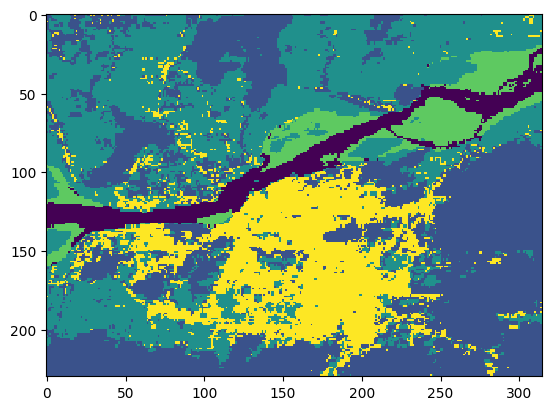

In [53]:
plt.imshow(class_prediction, cmap=plt.cm.viridis, interpolation='none')
plt.show()